#### 1️⃣ **Configuración e importación de librerías**

> **En esta celda importamos todas las librerías necesarias para manejo de audio, modelos, métricas de evaluación, manipulación de datos y visualización.
> También se definen las rutas principales y parámetros globales, incluyendo el modelo a evaluar y la base de datos de referencia.**

---



In [16]:
# Importa librerías necesarias para audio, manejo de modelos, métricas y visualización
import os
import numpy as np
import soundfile as sf
import sqlite3
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from jiwer import wer, cer
import matplotlib.pyplot as plt

# Configura rutas y parámetros principales
DB_PATH = "test_set.db"                     # Base de datos SQLite con audios y transcripciones
MODEL_PATH = "RebecaLeyva/whisper-finetuned-parra-v2"              # Carpeta del modelo fine-tuneado
WHISPER_MODEL = "openai/whisper-large-v3"           # Modelo base para comparar
BATCH_SIZE = 16                                     # Tamaño de batch (no utilizado aquí, pero puedes ajustar si vectorizas)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Usa GPU si está disponible


#### 2️⃣ **Cargar la lista de archivos y ground truth**

> **Esta celda define una función para leer la base de datos SQLite, extrayendo los nombres de archivo, rutas de audio y transcripciones de referencia (ground truth) para todos los audios incluidos en el análisis.
> Así obtenemos la lista de muestras para la evaluación.**

---




In [17]:
# Función para cargar desde SQLite la lista de archivos incluidos y sus transcripciones
def load_included_audios(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute("SELECT fname, audio_path, transcription FROM audios")
    data = c.fetchall()
    conn.close()
    return data  # Lista de tuplas: (fname, audio_path, transcription)

included_audios = load_included_audios()
print(f"Total archivos incluidos: {len(included_audios)}")


Total archivos incluidos: 534


#### 3️⃣ **Función de transcripción usando un modelo**

> **Aquí se implementa una función que recibe el modelo y processor de Hugging Face junto con la ruta del audio, procesa el archivo (forzando idioma español), y retorna la transcripción generada por el modelo.
> Se asegura de convertir cualquier audio multicanal a mono para evitar errores.**

---

In [18]:
# Transcribe un archivo de audio usando el modelo y processor de transformers (forzando idioma español)
def transcribe_audio(model, processor, audio_path):
    audio_data, sr = sf.read(audio_path)
    # Convierte a mono si el audio es multicanal
    if len(audio_data.shape) > 1:
        audio_data = np.mean(audio_data, axis=1)
    # Procesa el audio para el modelo
    proc = processor(
        audio_data,
        sampling_rate=sr,
        return_tensors="pt",
        padding="max_length",
        language="es"  # Fuerza español siempre
    )
    # Extrae features y corre inferencia
    input_features = proc["input_features"].to(DEVICE, torch.float16 if torch.cuda.is_available() else torch.float32)
    with torch.no_grad():
        generated_ids = model.generate(
            input_features,
            max_new_tokens=444,
            return_timestamps=False,
            do_sample=False,
            generation_config=None,
        )
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text.strip()


#### 4️⃣ **Cargar ambos modelos (fine-tuneado y Whisper base) solo una vez**

> **Esta celda define y utiliza una función que carga en memoria los dos modelos a comparar:
> (a) tu modelo fine-tuneado, y (b) Whisper Large v3 original.
> Así, las transcripciones de todos los audios se harán en condiciones idénticas para ambos.**

---

In [19]:
# Carga el modelo y processor desde Hugging Face o carpeta local
def load_model_and_processor(model_path):
    processor = AutoProcessor.from_pretrained(model_path)
    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model_path,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        low_cpu_mem_usage=True
    ).to(DEVICE)
    return model, processor

print("Cargando modelo propio...")
my_model, my_proc = load_model_and_processor(MODEL_PATH)

print("Cargando modelo Whisper large v3...")
whisper_model, whisper_proc = load_model_and_processor(WHISPER_MODEL)


Cargando modelo propio...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Cargando modelo Whisper large v3...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### 5️⃣ **Procesar audios y calcular WER/CER para cada modelo**

> **En esta celda se procesan todos los audios uno a uno:
> para cada archivo, se calcula la transcripción de ambos modelos, se normalizan los textos, y se computan las métricas de error WER (Word Error Rate) y CER (Character Error Rate).
> Los resultados se guardan para análisis y visualización posterior.**

---

In [20]:
# Inicializa listas para guardar resultados de ambos modelos
mymodel_wer, whisper_wer = [], []
mymodel_cer, whisper_cer = [], []
resultados = []

# Recorre cada audio y compara transcripciones
for idx, (fname, audio_path, gt_text) in enumerate(included_audios):
    print(f"Procesando {fname} ({idx+1}/{len(included_audios)})")
    # Transcripción con tu modelo
    pred_my = transcribe_audio(my_model, my_proc, audio_path)
    # Transcripción con Whisper base
    pred_whisper = transcribe_audio(whisper_model, whisper_proc, audio_path)
    # Normaliza textos (minúsculas, strip)
    gt = gt_text.strip().lower()
    pred_my = pred_my.strip().lower()
    pred_whisper = pred_whisper.strip().lower()
    # Calcula métricas
    my_w = wer(gt, pred_my)
    wh_w = wer(gt, pred_whisper)
    my_c = cer(gt, pred_my)
    wh_c = cer(gt, pred_whisper)
    mymodel_wer.append(my_w)
    whisper_wer.append(wh_w)
    mymodel_cer.append(my_c)
    whisper_cer.append(wh_c)
    resultados.append({
        "fname": fname,
        "gt": gt,
        "pred_my": pred_my,
        "pred_whisper": pred_whisper,
        "my_wer": my_w,
        "whisper_wer": wh_w,
        "my_cer": my_c,
        "whisper_cer": wh_c
    })


Procesando CMPT_F_01_0010.wav (1/534)
Procesando CMPT_F_01_0013.wav (2/534)
Procesando CMPT_F_01_0014.wav (3/534)
Procesando CMPT_F_01_0015.wav (4/534)
Procesando CMPT_F_01_0017.wav (5/534)
Procesando CMPT_F_01_0020.wav (6/534)
Procesando CMPT_F_01_0021.wav (7/534)
Procesando CMPT_F_01_0023.wav (8/534)
Procesando CMPT_F_01_0034.wav (9/534)
Procesando CMPT_F_01_0035.wav (10/534)
Procesando CMPT_F_01_0037.wav (11/534)
Procesando CMPT_F_01_0038.wav (12/534)
Procesando CMPT_F_01_0044.wav (13/534)
Procesando CMPT_F_01_0055.wav (14/534)
Procesando CMPT_F_01_0066.wav (15/534)
Procesando CMPT_F_01_0072.wav (16/534)
Procesando CMPT_F_01_0077.wav (17/534)
Procesando CMPT_F_01_0083.wav (18/534)
Procesando CMPT_F_01_0084.wav (19/534)
Procesando CMPT_F_01_0102.wav (20/534)
Procesando CMPT_F_01_0104.wav (21/534)
Procesando CMPT_F_01_0111.wav (22/534)
Procesando CMPT_F_01_0119.wav (23/534)
Procesando CMPT_F_01_0126.wav (24/534)
Procesando CMPT_F_01_0140.wav (25/534)
Procesando CMPT_F_01_0143.wav (26/

#### 6️⃣ **Mostrar resumen estadístico de métricas**

> **Aquí se definen funciones y se imprime un resumen estadístico (media, mediana, desviación, máximo, mínimo) de las métricas WER y CER para ambos modelos.
> Esto permite comparar su desempeño de manera numérica global.**

---

In [21]:
# Función para imprimir estadísticas básicas de las métricas
def resumen(nombre, scores):
    print(f"== {nombre} ==")
    print(f"Media: {np.mean(scores):.3f}")
    print(f"Desviación estándar: {np.std(scores):.3f}")
    print(f"Mediana: {np.median(scores):.3f}")
    print(f"Máximo: {np.max(scores):.3f}")
    print(f"Mínimo: {np.min(scores):.3f}")

print("\n== MÉTRICAS WER ==")
resumen("Tu modelo", mymodel_wer)
resumen("Whisper v3", whisper_wer)
print("\n== MÉTRICAS CER ==")
resumen("Tu modelo", mymodel_cer)
resumen("Whisper v3", whisper_cer)



== MÉTRICAS WER ==
== Tu modelo ==
Media: 0.059
Desviación estándar: 0.065
Mediana: 0.044
Máximo: 0.333
Mínimo: 0.000
== Whisper v3 ==
Media: 0.260
Desviación estándar: 0.135
Mediana: 0.250
Máximo: 0.875
Mínimo: 0.000

== MÉTRICAS CER ==
== Tu modelo ==
Media: 0.024
Desviación estándar: 0.029
Mediana: 0.014
Máximo: 0.168
Mínimo: 0.000
== Whisper v3 ==
Media: 0.105
Desviación estándar: 0.085
Mediana: 0.089
Máximo: 0.659
Mínimo: 0.000


#### 7️⃣ **Graficar boxplots comparativos de WER y CER**

> **En esta celda se generan boxplots que visualizan y comparan la distribución de errores (WER y CER) de ambos modelos.
> Es útil para ver diferencias en dispersión y valores atípicos entre ambos enfoques.**

---

C:\Users\luken\AppData\Local\Temp\ipykernel_30168\3329384430.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mymodel_wer, whisper_wer], labels=['Tu modelo', 'Whisper v3'])
C:\Users\luken\AppData\Local\Temp\ipykernel_30168\3329384430.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mymodel_cer, whisper_cer], labels=['Tu modelo', 'Whisper v3'])


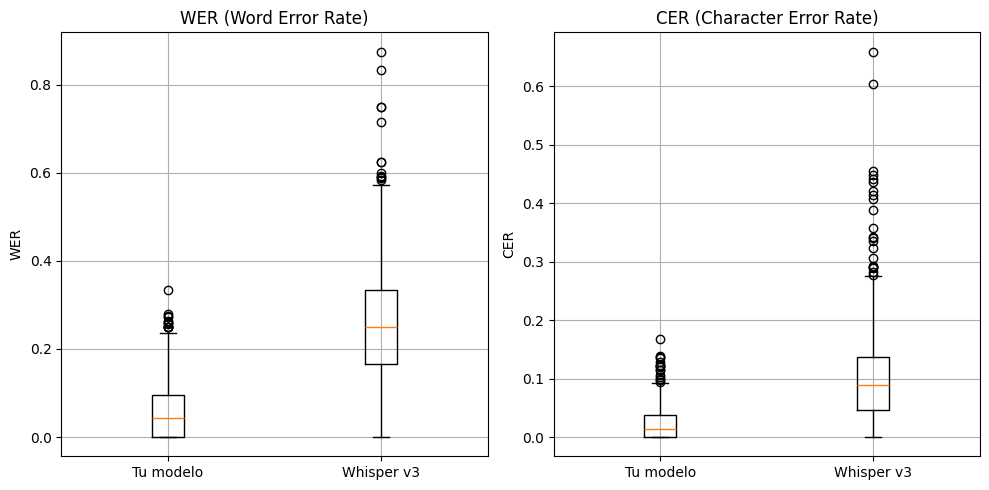

In [22]:
# Boxplots comparativos para visualizar la distribución de errores de cada modelo
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot([mymodel_wer, whisper_wer], labels=['Tu modelo', 'Whisper v3'])
plt.title('WER (Word Error Rate)')
plt.ylabel('WER')
plt.grid(True)

plt.subplot(1,2,2)
plt.boxplot([mymodel_cer, whisper_cer], labels=['Tu modelo', 'Whisper v3'])
plt.title('CER (Character Error Rate)')
plt.ylabel('CER')
plt.grid(True)

plt.tight_layout()
plt.show()


#### 8️⃣ **Guardar resultados detallados a CSV**

> **Aquí se guarda todo el detalle de resultados (archivos, transcripciones, métricas) en un archivo CSV para análisis, revisión o visualización futura fuera del notebook.**

---

In [23]:
# Guarda todas las transcripciones y métricas a un archivo CSV para análisis posterior
import pandas as pd
pd.DataFrame(resultados).to_csv("comparacion_modelos_resultados.csv", index=False)


#### 9️⃣ **Pruebas estadísticas para comparar modelos**

> **Esta celda realiza análisis estadístico formal sobre las diferencias de WER y CER entre modelos:
> primero evalúa si la diferencia sigue una distribución normal (Shapiro), y luego usa la prueba de Wilcoxon (no paramétrica) o t-test pareado (paramétrica) según corresponda.
> El objetivo es saber si la diferencia de desempeño es estadísticamente significativa.**

---

In [24]:
from scipy.stats import wilcoxon, ttest_rel, shapiro

# Analiza si las diferencias WER y CER entre modelos son significativas
diff_wer = np.array(mymodel_wer) - np.array(whisper_wer)
stat, pnorm_wer = shapiro(diff_wer)
if pnorm_wer < 0.05:
    print(f"[WER] No es normal, Wilcoxon. p_norm = {pnorm_wer:.4f}")
    stat, pval_wer = wilcoxon(mymodel_wer, whisper_wer, alternative="two-sided")
else:
    print(f"[WER] Dif. normal, t pareada. p_norm = {pnorm_wer:.4f}")
    stat, pval_wer = ttest_rel(mymodel_wer, whisper_wer)
print(f"p-valor para diferencia entre modelos (WER): p = {pval_wer:.4g}")
if pval_wer < 0.05:
    print("✅ Diferencia estadísticamente significativa (p<0.05)")
else:
    print("❌ No hay diferencia significativa (p>=0.05)")

# CER
diff_cer = np.array(mymodel_cer) - np.array(whisper_cer)
stat, pnorm_cer = shapiro(diff_cer)
if pnorm_cer < 0.05:
    print(f"[CER] No es normal, Wilcoxon. p_norm = {pnorm_cer:.4f}")
    stat, pval_cer = wilcoxon(mymodel_cer, whisper_cer, alternative="two-sided")
else:
    print(f"[CER] Dif. normal, t pareada. p_norm = {pnorm_cer:.4f}")
    stat, pval_cer = ttest_rel(mymodel_cer, whisper_cer)
print(f"p-valor para diferencia entre modelos (CER): p = {pval_cer:.4g}")
if pval_cer < 0.05:
    print("✅ Diferencia estadísticamente significativa (p<0.05)")
else:
    print("❌ No hay diferencia significativa (p>=0.05)")


[WER] No es normal, Wilcoxon. p_norm = 0.0000
p-valor para diferencia entre modelos (WER): p = 8.245e-86
✅ Diferencia estadísticamente significativa (p<0.05)
[CER] No es normal, Wilcoxon. p_norm = 0.0000
p-valor para diferencia entre modelos (CER): p = 7.921e-85
✅ Diferencia estadísticamente significativa (p<0.05)


#### 🔟 **Graficar boxplots finales con anotaciones de significancia**

> **Se generan boxplots mejorados para WER y CER, agregando corchetes y etiquetas de significancia estadística según el resultado de las pruebas previas.
> Esto comunica visualmente si las diferencias observadas son relevantes a nivel científico.**

---

C:\Users\luken\AppData\Local\Temp\ipykernel_30168\3787825025.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mymodel_wer, whisper_wer], labels=['Tu modelo', 'Whisper v3'], patch_artist=True)
C:\Users\luken\AppData\Local\Temp\ipykernel_30168\3787825025.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mymodel_cer, whisper_cer], labels=['Modelo Parra Postpartum', 'Whisper v3'], patch_artist=True)


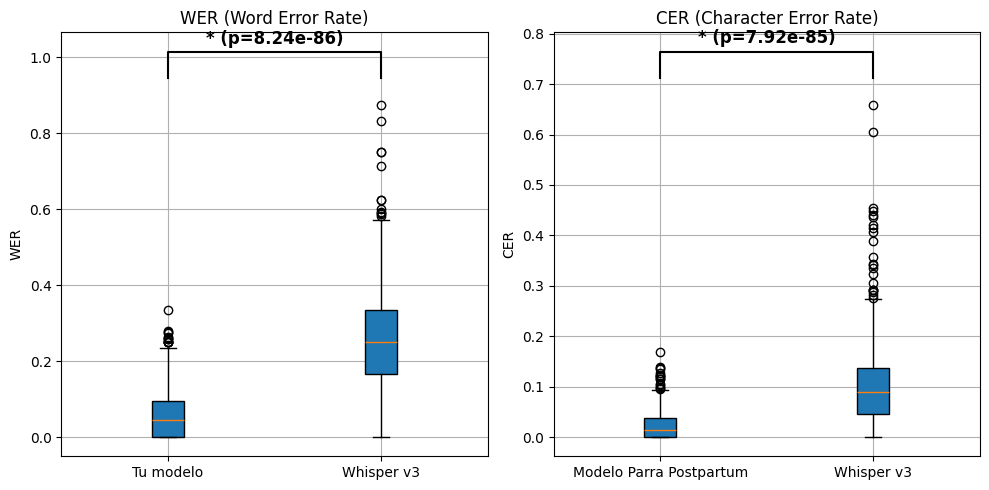

In [25]:
# Función para añadir corchete y etiqueta de significancia en boxplot
def add_significance(ax, x1, x2, y, h, p, label=None):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    if p < 0.05:
        star = "*"
    else:
        star = "ns"
    label = label if label else f"{star} (p={p:.3g})"
    ax.text((x1+x2)/2, y+h+0.01, label, ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot([mymodel_wer, whisper_wer], labels=['Tu modelo', 'Whisper v3'], patch_artist=True)
plt.title('WER (Word Error Rate)')
plt.ylabel('WER')
plt.grid(True)
y_max = max(max(mymodel_wer), max(whisper_wer))
h = (y_max) * 0.08
ax1 = plt.gca()
add_significance(ax1, 1, 2, y_max + h, h, pval_wer)

plt.subplot(1,2,2)
plt.boxplot([mymodel_cer, whisper_cer], labels=['Modelo Parra Postpartum', 'Whisper v3'], patch_artist=True)
plt.title('CER (Character Error Rate)')
plt.ylabel('CER')
plt.grid(True)
y_max = max(max(mymodel_cer), max(whisper_cer))
h = (y_max) * 0.08
ax2 = plt.gca()
add_significance(ax2, 1, 2, y_max + h, h, pval_cer)

plt.tight_layout()
plt.show()
